<a href="https://colab.research.google.com/github/patty1997/Deep_Learning_Projects/blob/main/Inception_Resnet_V2_SGD_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
#from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
# from keras.preprocessing import image_dataset_from_directory
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.initializers import he_uniform, glorot_uniform
#from keras.optimizers import SGD,Adam,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.regularizers import l1,l2,l1_l2

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Data/train_set"
validation_dir = "/content/drive/MyDrive/Colab Notebooks/Data/test_set"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Data/random_test_set"

In [ ]:
train_datagen = ImageDataGenerator(
                                    rotation_range = 18,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    preprocessing_function = preprocess_input,
                                    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode = 'binary',
                                                    batch_size = 1396,
                                                    target_size = (224,224))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        class_mode = 'binary',
                                                        batch_size = 598,
                                                        target_size = (224,224))



Found 1396 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


In [ ]:
x_train, y_train = train_generator.next()
x_test, y_test = validation_generator.next()
print(x_train.shape)
print(y_train.shape)

(1396, 224, 224, 3)
(1396,)


In [ ]:
ir_model = InceptionResNetV2(input_shape=(224,224,3),
                                 include_top = False,
                                 weights = 'imagenet')
count=0
for layer in ir_model.layers:
  layer.trainable = False
  count=count+1;
ir_model.summary()
print(count);

219070464/219055592 [==============================] - 11s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________

In [ ]:
feature_extractor  = Sequential([ir_model,Flatten()])

In [ ]:
X_for_ML = feature_extractor.predict(x_train)
x_test_feature = feature_extractor.predict(x_test)

In [ ]:
from sklearn import svm
from sklearn import linear_model
model = linear_model.SGDClassifier(max_iter = 1000, tol=1e-3) 
model.fit(X_for_ML, y_train)
prediction = model.predict(x_test_feature)

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators = 128, random_state = 42)
# model.fit(X_for_ML, y_train)
# prediction = model.predict(x_test_feature)

# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# prediction = gnb.fit(X_for_ML, y_train).predict(x_test_feature)
# print("Number of mislabeled points out of a total %d points : %d"
#       % (x_test_feature.shape[0], (y_test !=prediction).sum()))


In [ ]:
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction))
print("F1Score = ", metrics.f1_score(y_test, prediction))
print("Precision = ", metrics.precision_score(y_test, prediction))
print("Recall = ", metrics.recall_score(y_test, prediction))

Accuracy =  0.9615384615384616
F1Score =  0.9624796084828711
Precision =  0.9394904458598726
Recall =  0.9866220735785953


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

[[280  19]
 [  4 295]]


InceptionResNetV2 - SGD Classifier: ROC AUC=0.962


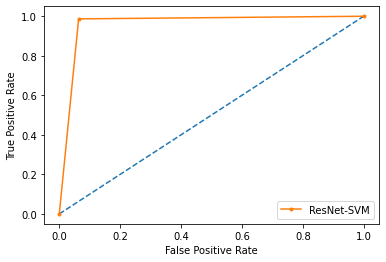

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
# keep probabilities for the positive outcome only
from sklearn.metrics import roc_auc_score, roc_curve
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, prediction)
# summarize scores
# print('Center: ROC AUC=%.3f' % (ns_auc))
print('InceptionResNetV2 - SGD Classifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, prediction)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='ResNet-SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()